# Heterogeneous Graphs
So far, all the discussion has been about graphs with one edge type and one node type (homogeneous); complexity arises then once graphs with multiple edge and node types are considered and thus require differnt approaches. Due to this added complexity, a heterogeneous graph is defined as $G=(V,R,T,E)$ (there are other definitions), where nodes with node types $v_i\in V$ (node type $T(v_i)$), and relations with relation types $(v_i,e,v_j)\in R$ (edge type $e\in E$).

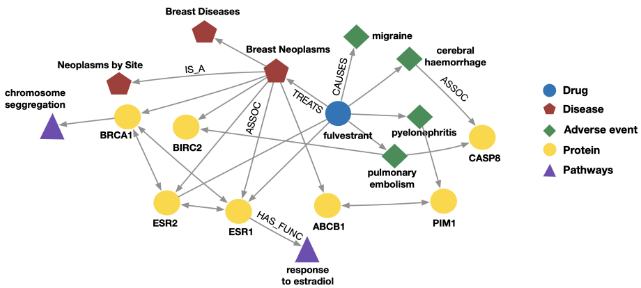

A good benchmark for heterogeneous graphs is the https://ogb.stanford.edu/docs/nodeprop/ from Microsoft Academic Graph (MAG) which has 4 types of entities; papers (736k nodes), authors (1.1m nodes), institutions (9k nodes), and fields of study (60k nodes)

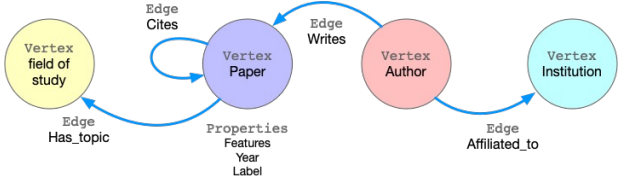

The most naive approach is to treat types of nodes and edges as features (add one-hot indicator for nodes and edges, etc.), reducing the heterogeneous graph to a standard graph. Even though heterogeneous graphs are more express representation (captures different interaction types between entities), it is more expensive for computations, storage, and requires a more complex implementation; additionally, there are other ways to convert a heterogeneous graph into a standard one , and it thus raises the question as to "when a heterogeneous graph is needed"? It is exclusively required for situations where:
- Different node/edge types have differetne shape of features (an "author node" has 4 dimensional feature as opposed to a "paper node" has 5 dimensional feature).
- differetn relation types represent differetn types of interactions ($(\text{English}, \text{translate}, \text{French})$ and $(\text{English}, \text{translate}, \text{Chinese})$ require different models)

## Relational GCN
Consider a directed graph (same approach as undirected but message propogates only in direction of edge) with one relation (type).  If the graph has multiple relation types, it would need different neural networks for different relation types. 

<table><tr><td>

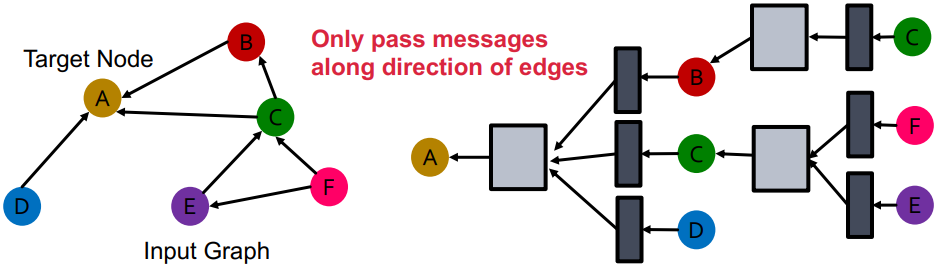
</td><td>

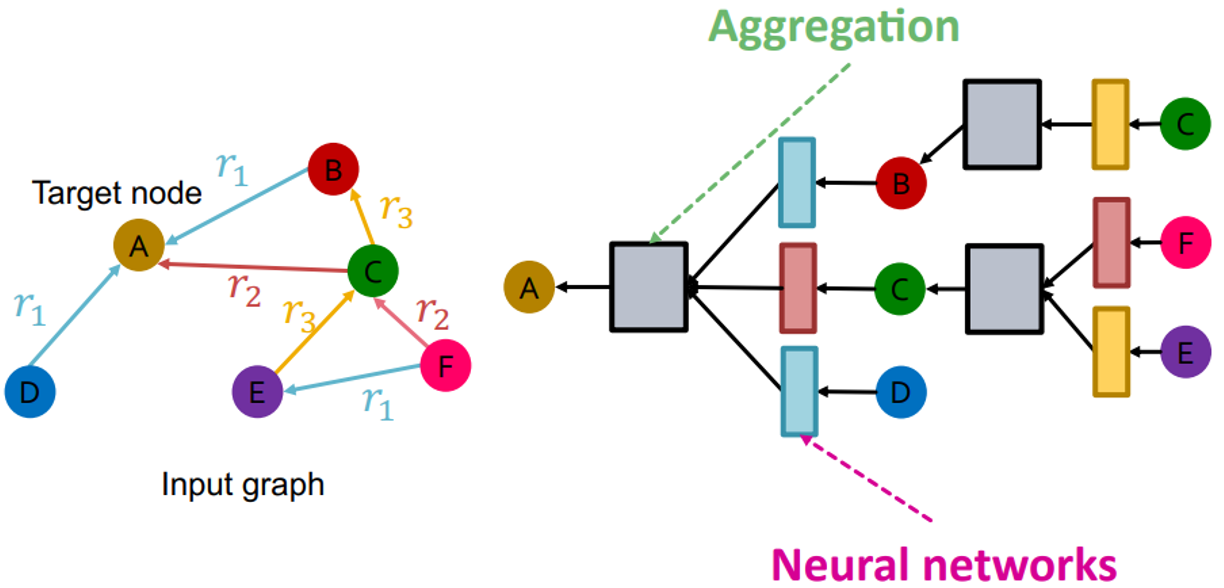
</td></tr></table>

Therefore, recalling the basic GCN model layer for homogeneous graphs (without self injection), a new layer can be defined for a heterogeneous graph $$h_{i}^{(k-1)}=\sigma(\sum_{r\in R}\sum_{N_1(i,r)}W^{(k-1)}_r\frac{h_j^{(k)}}{|N_1(i,r)|}+B^{(k-1)}h_i^{(k)})$$
$i\in N_{k-1}(v),\;h_i^{K}=\text{x}_i$, $\forall k\in\{K,\ldots,0\}$, where $N_1(i,r)=\{j\in N_1(i): i\rightsquigarrow j=r\}$, and $i\rightsquigarrow j$ is the relation between nodes $i$ and $j$.

This means that each relation has $L$ matrices, each with dimension $W^{(k)}_r\in\mathbb{R}^{d^{(k-1)}}\times\mathbb{R}^{d^{(k)}}$; making the numbers of parameteres rapidly grow relative to the number of relations (overfitting becomes an issue). There are 2 methods to regularize the weight of $W^{(k)}_r$
1. **Block Diagonal Matrices**: It is possible to make the weights sparse, where only nearby neurons/dimensions can interact throuhgh $W$. Specifically, using block diagonal matrices for $W_r$ reduces the dimensionality from ${d^{(k-1)}}\times{d^{(k)}}$ to $\mathbb{B}\times\frac{d^{(k-1)}}{\mathbb{B}}\times\frac{d^{(k)}}{\mathbb{B}}$ where $\mathbb{B}\times\mathbb{B}$ is the dimensionality of the diagonal blocks.
2. **Basis/Dictionary Learning**: A different approach is to share weights across different relations, representing the matrices of each relation as a linear combination of basis transformations, $W_r=\sum_{b=1}^{\mathbb{B}}a_{rb}V_b$ (where $V_b$ is shared across all relations); and the objective becomes to learn $\{\{a_{rb}\}_{b=1}^{\mathbb{B}}\}_{r\in R},\{V_b\}_{b=1}^{\mathbb{B}}$ ($\{a_{rb}\}_{b=1}^{\mathbb{B}}$ is a $\mathbb{B}$ scalar) instead of $\{W_r\}_{r\in R}$

Training and predictions are then made using the same procedure as for standard graphs; with the added complexity that is introduced by the fact that instead of a single GCN, multiples are working together, interwoven to one another. Further, the idea realised in RGCN can be extended into RGNN (RGraphSAGE, RGAT, etc.>)

## Knowledge Graph (KG) Embedding
Knowledge Graphs are an example of heterogeneuos graphs which captures real-world relationships between entities, with the main task being *KG Completion*, $(v_i,e)\rightarrow (v_i,e,v_j)$; for a given a head node $v_i$ and edge type $e$, predict the missing tail node $v_j$ of the relation.

This can be achieved by modeling entities and relations in embeddings space $\mathbb{R}^k$ such that the embeddings of $(v_i,e)$ is close to the emebdding of $v_j$. This method can therefore exhibit the following patterns within the embedding space.

- **Symmetric relations**: $r(h,t)\rightarrow r(t,h)$
- **Antisymmetric relations**: $r(h,t)\rightarrow \neg r(t,h)$
- **Inverse relations**: $r_2(h,t)\rightarrow r_1(t,h)$
- **Composition (Transitive) relations**: $r_1(x,y) \cap r_2(y,z)\rightarrow r_3(x,z)$
- **1-to-N relations**: $r(h,t_1),r(h,t_2),\ldots,r(h,t_n)$ mare all *true*

### TransE
For a relation $(v_i,e,v_j)$, let $v_i,e,v_j\in\mathbb{R}^k$ be embedding vectors such that $v_i+e\approx v_j$ if the given link exists, else $v_i+e\neq v_j$. With this model, a scoring function can then be $f_e(v_i,v_j)=-||v_i+e-v_j||$

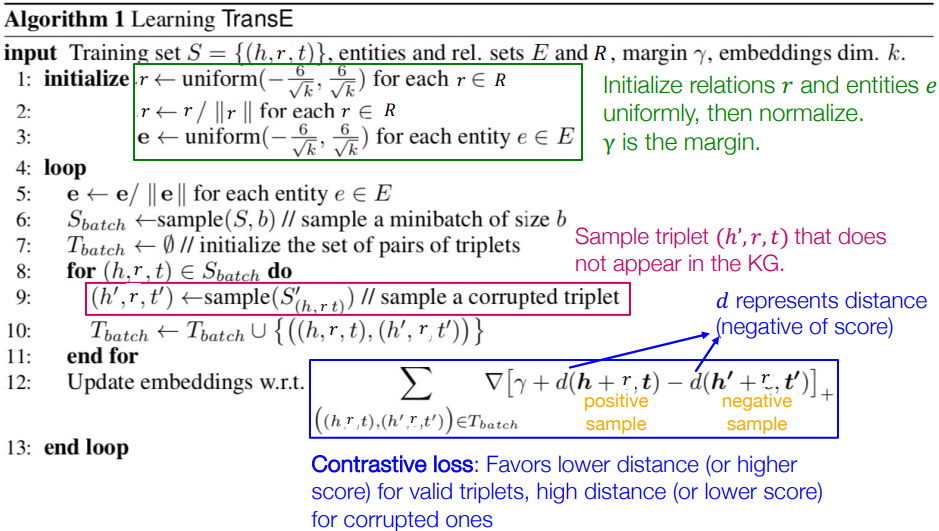
- **Symmetric relations**: given $h+r=t$, for $t+r=h$, $r=0$ and $h=t$. However, $h$ and $t$ are two different entities and should be mapped to different locations; thus *TransE* cannot model symmetric relations.
- **Antisymmetric relations**: given $h+r=t$, then $t+r=h+2r\neq h$ (unless $r=0$ which should not occur as per above).
- **Inverse relations**: given $h+r_2=t$, then $t+r_1=h$ by setting $r_1=-r_2$.
- **Composition (Transitive) relations**: given $x+r_1=y$ and $y+r_2=z$, then $x+r_3=z$ by settign $r_3=r_1+r_2$.
- **1-to-N relations**: Similar to *symmetric relations*, this too cannot be modelled.

### TransR
For a relation $(v_i,e,v_j)$, let $v_i,v_j\in\mathbb{R}^d$, $e\in\mathbb{R}^k$ be embedding vectors such that given $M_e\in\mathbb{R}^k\times\mathbb{R}^d$, $v_{i_\bot}+e\approx v_{j_\bot}$, where $M_ev_i=v_{i_\bot}$. With this model, a scoring function can then be $f_e(v_i,v_j)=-||v_{i_\bot}+e-v_{j_\bot}||$

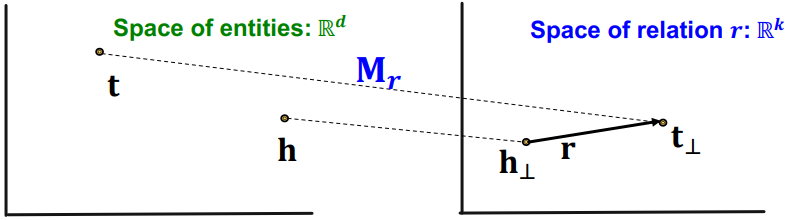
- **Symmetric relations**: by having $M_r$ map both $t$ and $h$ to teh same position, $r$ can then be $0$ such that $h_\bot=M_rh=M_rt=t_\bot$ without $h=t$.
- **Antisymmetric relations**: if $r\neq 0$, then $M_rh+r=M_rt$ and so $M_rt+r=M_rh+2r\neq M_rh$.
- **Inverse relations**: By letting $M_{r_1}=M_{r_2}$ and $r_2=-r_1$, if $M_{r_1}h+r_1=M_{r_1}t$ then $M_{r_2}t+r_2=M_{r_1}t+r_2=M_{r_1}h+r_1-r_1=M_{r_1}h=M_{r_2}h$.
- **Composition (Transitive) relations**: Given the kernel space of a matrix $M$ is defined by $h\in\text{Ker}(M)\rightarrow Mh=0$, $M_{r_1}g_1=r_1$, and $M_{r_2}g_2=r_2$; as $r_1(x,y)$ exists, then $M_{r_1}x+r_1=M_{r_1}y\rightarrow M_{r_1}(y-x)=r_1$ and so $y-x\in g_1+\text{Ker}(M_{r_1})\rightarrow y\in x+g_1+\text{Ker}(M_{r_1})$. The same applied to $r_2(y,z)$ and so $z\in y+g_2+\text{Ker}(M_{r_2})\rightarrow z\in x+g_1+g_2+\text{Ker}(M_{r_1})+\text{Ker}(M_{r_2})$, thus construct $M{r_3}$ such that $\text{Ker}(M_{r_3})=\text{Ker}(M_{r_1})+\text{Ker}(M_{r_2})$ and set $r_3=M_{r_3}(g_1+g_2)$ such that $M_{r_3}x+r_3=M_{r_3}z$.
- **1-to-N relations**: Similar to *symmetric relations*, this too can be modelled by mapping all $N$ tails to the same point (not required to be the same point as head).

### DistMult
Taking the idea from binlinear modeling (score function $f_e(v_i,v_j)=v_iA_ev_j$ $h,t\in\mathbb{R}^k$ and $A_e\in\mathbb{R}^k\times\mathbb{R}^k$ is too general and prone to overfitting), let $v_i,e,v_j\in\mathbb{R}^k$ be embedding vectors such that the score function $f_e(v_i,v_j)=\langle v_i,e,v_j\rangle=\sum_d v_{i_d}e_dv_{j_d}$ (can be viewed as a cosine similarity between $v_ie$ adn $v_j$).
- **Symmetric relations**: $\langle h,r,t\rangle=\sum_i h_ir_it_i = \langle t,r,h\rangle$.
- **Antisymmetric relations**: This cannot be modelled due to the above behaviour.
- **Inverse relations**: due to the *Symmetric relations* behaviour, *Inverse relations* cannot be modelled semantically either (can have $r_1=r_2$ which semantically does not make sense).
- **Composition (Transitive) relations**: Due to the same semantical reason as above, *Composition relations* cannot be modelled.
- **1-to-N relations**: $\langle h,r,t_1\rangle=\langle h,r,t_2\rangle$ can be modelled such that this relation is described.

### ComplEx
Based on *DistMult* and using the complex vector space $\mathbb{C}^k$ such that the score function $f_r(h,t)=\text{Re}(\sum_i h_ir_i\bar{t_i})=\langle \text{Re}(h_i),\text{Re}(r_i),\text{Re}(t_i)\rangle+\langle \text{Re}(h_i),\text{Im}(r_i),\text{Im}(t_i)\rangle+\langle \text{Im}(h_i),\text{Re}(r_i),\text{Im}(t_i)\rangle-\langle \text{Im}(h_i),\text{Im}(r_i),\text{Re}(t_i)\rangle$
- **Symmetric relations**: When $\text{Im}(r)=0$, then $f_r(h,t)=f_r(t,h)$ and so can be learned.
- **Antisymmetric relations**: The model is expressive enough to learn $f_r(h,t)=\text{Re}(\sum_i h_ir_i\bar{t_i})$ and $f_r(t,h)=\text{Re}(\sum_i t_ir_i\bar{h_i})$ due to the asymmetric modeling using complex conjugates.
- **Inverse relations**: When $\text{Im}(r_1)=-\text{Im}(r_2)$, then $f_{r_1}(h,t)=f_{r_2}(t,h)$ and so can be learned.
- **Composition (Transitive) relations**: Due to sharing the same property as *DisMult*, cannot model this relation (semantically wrong).
- **1-to-N relations**: Due to sharing the same property as *DisMult*, can model this relation (semantically wrong).


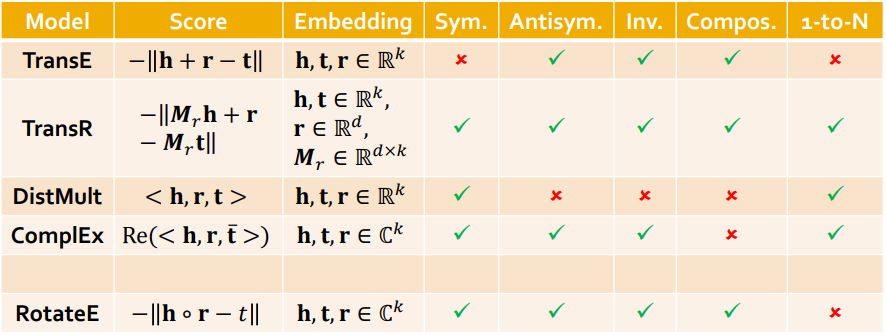

## Reasoning around KG in Vector Space
Now consider arbitrary path-based queries (one-hop, path, conjuctive) on a incomplete and unknown KG. Traversal cannot be done as the graph is incomplete and so some tails will be un-discovered. Additionally, KG completion cannot be applied to the KG and then apply traversal as it would mean a desnse graph traversal which would exponentially increase time complexity to $O(d_{\max}^L)$ (path of length $L$).

Thus, an approach which answers these arbitrary path-based queries must implicitly impute for missing information (account for the incompleteness of KG); similar to making complex predictions.

### Path Queries
KG embeddings, specifically *TransE* due to its composition property (*TransR* has a more complex procedure), can then generalise multi-hop reasoning; utilising the resultant vectors to traverse the vector space representation of KG without exhaustively analysing each path. Where before the path query $q=(v_a,(r_1,\ldots,r_n))$ was a complex and opaque task, in the created vector space the answer is simply the vector addition $q=v_a+r_1+\ldots+r_n$, independent of the number of entities in the KG (can then train *TransE* for multi-hop completion).

### Conjunctive Queries
https://arxiv.org/pdf/2002.05969
Queries involving multiple conditions which must all be satisfied simultaneously (intersection of multiple paths) also become complex and opaque when using traversal across incomplete KGs. As each hop can lead to more than one entity (e.i. human -eat-> ...), each intermediate node must represent a set of entities; and additionally, the intersection operation must be implemented for the latent space. 

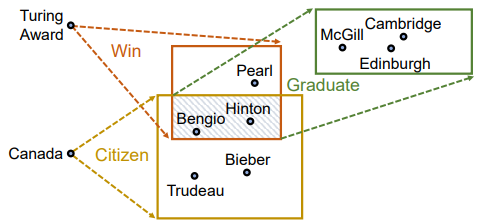

A solution to this added complexity is to embed queries with *hyper-rectangles*, where all answers for a given query are enclosed within $q=(\text{Centre}(q), \text{Offset}(q))$. Doing so, intersections are *well defined* (intersection will generate a resultant box) and thereby can be iteratively applied. Therefore, a new system is defined where:

- Each entity embeddings are zero-volume boxes ($d|V|$): $q=(\text{Centre}(q), 0)$
- Each relation embeddings are box-transformations ($2d|V|$): $\mathcal{P}:q\times r\rightarrow q'$ such that $q'=(\text{Centre}(q)+\text{Centre}(r), \text{Offset}(q)+\text{Offset}(r))$
- Intersection operator $\mathcal{J}:q_0\times\ldots\times q_n \rightarrow q'$ which generates a resultant box from inputted boxes. While a geometric method can be used (hard-coded), this can be done through the learnt operation $\text{Centre}(q')=\sum_iw_i\odot\text{Centre}(q_i)$ with $w_i=\frac{\text{exp}(f_{\text{Centre}}(\text{Centre}(q_i)))}{\sum_j\text{exp}(f_{\text{Centre}}(\text{Centre}(q_j)))}$ ($w_i$ calculated via a neural network representing a self-attention score for the centre of each input $\text{Centre}(q_i)$); which can be intuatively thought of as defining the center to be inside a box defined by the intersecting boxes' centres. $\text{Offset}(q')=\min\{\text{Offset}(q_1),\ldots,\text{Offset}(q_n)\}\odot\sigma(f_{\text{Offset}}(\text{Offset}(q_1),\ldots,\text{Offset}(q_n)))$ (neural network sigmoid function against the minimum offset to guarantee a smaller offset)

    - $\odot$ is the *Hadamard product*, which does element-wise product $A \odot B = A_{ij}\times B_{ij}$

A new score function therefore must be defined for this new system to capture information about whether an entity embedding $v$ is inside or outside (more important to be inside the box than as close as possible to the centre) the the given box $q$. Therefore, a function to determine the distance between $v$ and $q$ as $d_{\text{box}}(q,v)=d_{\text{out}}(q,v)+\alpha d_{\text{in}}(q,v)$ where $0<\alpha<1$, with the score function $f_q(v)=-d_{\text{box}}(q,v)$.

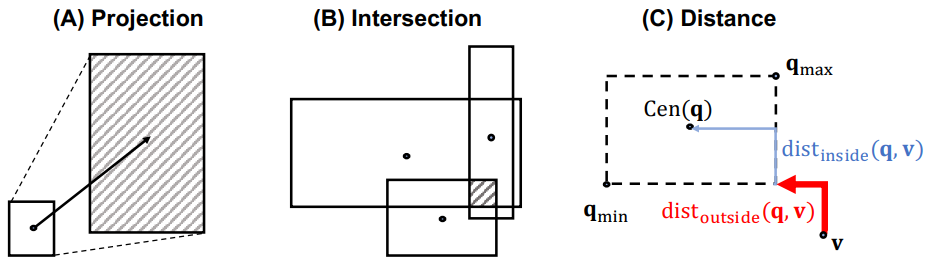

#### Disjunction queries
While it seems logical that this idea can then be extended to designing a disjunction operator and embed AND-OR queries (Existential Positive First-Order queries); this is not the case as given any $M$ conjuctive queries $q_1,\ldots,q_M$ with non-overlapping answers, a dimentionality of $\Theta(M)$ is needed to handle all (arbitrary) OR queries.

This means that union operations cannot be used within the *query plan*; however, this can be solved by changing the *query plans* such that a single union operation is only done at the end (sub-queries only using conjuctive operators) and it would not matter that a box is not generated (caveat size of query increases exponentially).

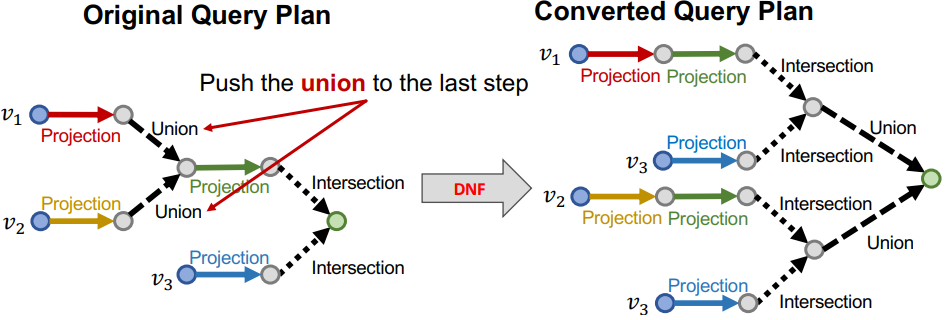

The distance then needs to be changed such that $d_{\text{box}}(q,v)=\min\{d_{\text{box}}(q_1,v),\ldots,d_{\text{box}}(q_m,v)\}$ becuase as long as $v$ is teh answer to one conjunctive query $q_i$, then $v$ should be the answer to $q$.